In [73]:
"""Module providing access to creating namedtuple structures"""
import collections
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf
import tensorflow_probability as tfp

# Preamble

In [74]:
sns.set_theme()

In [75]:
# Aliasing
DTYPE = tf.float64

tfd = tfp.distributions

tf_map = tf.nest.map_structure

# User defined types

In [76]:
# User defined types
ParameterTuple = collections.namedtuple(
    'ParameterTuple', 'mean')

ParameterTupleV2 = collections.namedtuple(
    'ParameterTuple', 'mean variance')

McmcResult = collections.namedtuple(
    'McmcResult', 'is_accepted current_state current_state_log_prob')

# Data simulation 

In [77]:
# Data creation - toy example

toy_param = {'loc': tf.constant(3.5, dtype=DTYPE),
             'scale': tf.constant(1.34, dtype=DTYPE)
             }

toy_gaussian = tfp.distributions.Normal(
    loc=toy_param['loc'],
    scale=toy_param['scale']).sample(
    100, seed=20060420)

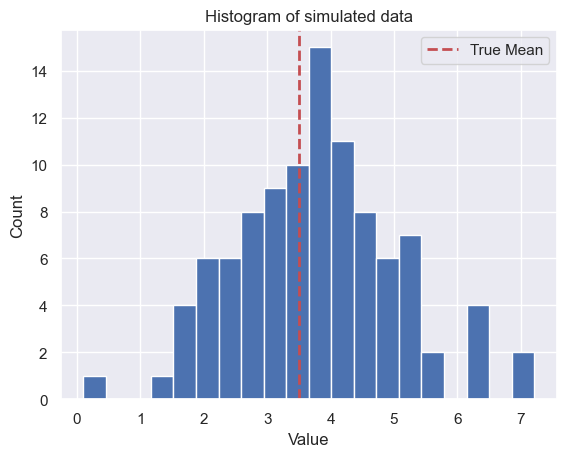

In [78]:
fig, ax = plt.subplots()
pd.DataFrame(toy_gaussian).hist(bins = 20, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Value')
ax.set_title('Histogram of simulated data')
ax.axvline(x = 3.5, color='r', linestyle='--', label='True Mean',linewidth =2)
ax.legend()

# Target log prob function 

In [79]:
def toy_log_ll(data):
    """log-likelihood for a normal distribution

    Args:
        data (float64): sample of a noraml distribution
    """
    def target_log_prob(parameters):
        # prior distribution
        prior_dist = tfp.distributions.Normal(
            loc=tf.constant(0., DTYPE), 
            scale=tf.constant(10., DTYPE)).log_prob(parameters)

        # likelihood
        log_ll_eval = tfp.distributions.Normal(
            loc=parameters, scale=tf.constant(1.34, dtype=DTYPE, name = 'known_mean')).log_prob(data)
        return tf.reduce_sum(log_ll_eval) + tf.reduce_sum(prior_dist)

    return target_log_prob

In [80]:
# partial functions fixing each parameter so they can be mapped to their own kernels
def toy_log_ll_v2(data):
    """
    Returns the log-likelihood function of a normal distribution for a given sample.

    Args:
    data: A float64 Tensor representing a sample from a normal distribution.

    Returns:
    A Tensor representing the log-likelihood of the sample.

    Raises:
    ValueError: If the data is not a float64 Tensor.
    """

    def target_log_prob(loc, scale):
        """
        Parameters (ParameterTupleV2): tuple defining the mean AND variance

        Returns:
          The log-likelihood of the sample under the given parameters.
        """
        # prior distribution
        prior_dist = tfp.distributions.Normal(
            loc=tf.constant(0., DTYPE),
            scale=tf.constant(10., DTYPE)).log_prob(loc) + \
                tfp.distributions.HalfNormal(tf.constant(10., DTYPE)).log_prob(scale)

        # likelihood
        log_ll_eval = tfp.distributions.Normal(
            loc=loc, scale=scale).log_prob(data)
        return tf.reduce_sum(log_ll_eval) + tf.reduce_sum(prior_dist)

    return target_log_prob

In [81]:
# partial function evaluation to get a partial target log prob
tlp_fixed_scale_moving_loc = functools.partial(toy_log_ll_v2(data=toy_gaussian),
                                               scale=tf.constant(1.34, dtype=DTYPE, name='fixed_variance'))
tlp_fixed_loc_moving_scale = functools.partial(toy_log_ll_v2(data=toy_gaussian),
                                               loc=tf.constant(2.0, dtype=DTYPE, name='fixed_mean'))

In [82]:
# eg. using the partial functions
tlp_fixed_scale_moving_loc(tf.constant(2.0, dtype=DTYPE, name='moving_loc')) == tlp_fixed_loc_moving_scale(
    scale=tf.constant(1.34, dtype=DTYPE, name='moving_scale'))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [83]:
toy_log_ll(toy_gaussian)(tf.constant(2.0, dtype=DTYPE,name='moving_loc'))

<tf.Tensor: shape=(), dtype=float64, numpy=-256.75671471477386>

In [84]:
def generate_partial_target_log_prob(target_log_prob_fn, **kwargs):
    """
    Reimplementation of the partial function evaluation in the functools package. 
    A target_log_prob_fn and a namedTuple of all the arguments the target_log_prob_fn
    takes. The inner closure takes a name-value pairing for the part of the 
    target_log_prob_fn which will be the subject of inference in the step. In other 
    words, it performs the Gibbs step of conditioning the target_log_prob_fn on *all* 
    model variables with the exception of one which corresponds to the accompaying
    TransitionKernel (this will perform a one_step evaluation on the target variable)

    Args:
        target_log_prob_fn: the target log-probability of the model
        **kwargs: a namedTuple of parameters and values. This is to be the current_state 
            of the chain
        
    Return:
        partial_target_log_prob_fn:
    """
    def partial_target_log_prob_fn(**target_kwargs):
        """
        Create an conditional probability function which takes only one arguement. Namely,
        the variable that is the scope of the current Gibbs step of the 
        Metropolis-within-Gibbs algorithm.
        
        Return: 
            target_log_prob_fn(**partial_kwargs, **kwargs): an evaluation of the target_log_prob_fn 
                with all variables fixed
        """
        return target_log_prob_fn(**partial_kwargs, **kwargs)

    return partial_target_log_prob_fn

In [121]:
tlp_loc = partial(toy_log_ll_v2(data=toy_gaussian), scale = tf.constant(2.0, dtype=DTYPE,name='fixed_scale'))

In [122]:
tlp_loc(loc = tf.constant(1.0, dtype=DTYPE,name='moving_loc'))

<tf.Tensor: shape=(), dtype=float64, numpy=-283.1942403673488>

# Proposal distribution creation

In [86]:
def generate_gaussian_proposal(scale):
    """Instantiate a Gaussian proposal for an MCMC kernel 

    Args:
        scale (float64): the scale of the proposal distribution. 
        Must contain only positive values. 

    Returns:
        fn: proposal function with a fixed scale parameter. The
        function takes in the current chain state and a seed, 
        and returns a sample of size 1 matching the current 
        state dimensions
    """
    scale = tf.cast(scale, DTYPE)
    def gaussian_proposal(current_state, seed):
        """Propose next state in an MCMC chain given a current
        state and a seed 

        Args:
            current_state (float64): vector of values of the 
            current chain state
            seed (int): PRNG seed

        Returns:
            float64: suggested next state for the chain
        """
        loc = tf.cast(current_state, DTYPE)
        isotropic_normal = tfp.distributions.Normal(
            loc=loc, scale=scale)
        return isotropic_normal.sample(seed=seed)
    return gaussian_proposal

In [87]:
def generate_gamma_proposal(distribution_parameters):
    # indepedence sampler? - Yes. 
    """_summary_

    Args:
        distribution_parameters (float64): list of parameters for the gamma distirbution, namely the [concentration, rate] values

    Returns:
        proposed_value (f ): function which proposed the next step in the chain
        log_acceptance_correction (fn): function which outputs the acceptance ratio correction
    """
    # initialize the distribution
    proposal_distribution = tfp.distributions.Gamma(
        concentration=distribution_parameters[0],       # alpha
        rate=distribution_parameters[1])                # beta

    def proposed_value(current_state, seed):
        return proposal_distribution.sample(
            sample_shape=tf.shape(current_state),
            seed=seed)

    def log_acceptance_correction(current_state, proposed_state):
        # q(x | x')
        backward_correction = proposal_distribution.log_prob(
            value=current_state, name='backward_correction')

        # q(x' | x)
        forward_correction = proposal_distribution.log_prob(
            value=proposed_state, name='forward_correction')

        return backward_correction - forward_correction

    return proposed_value, log_acceptance_correction

# RWMH kernel 

In [88]:
# inference algorithms

# random walk metropolis hastings
def random_walk_metropolis_hastings_kernel(target_log_prob_fn, initial_state, proposal_scale):
    """Runs one step of the Metropolis-Hastings algorithm.
    Proposal distribution is symmetric meaning there is
    no need for any adjustments to the log-acceptance ratio

    Args:
        target_log_prob_fn (fn): a *partial* evaluation of the
        model target log prob function which moves *only* the
        parameters of interest of the inference block 
        proposal_scale (float64): vector of the proposal
        distribution scales for the parameters of interest
        of the inference block

    Returns:
        current_state (float64): state of the chain after the step
        has been run
        kernel_result (RWMHResult): tracing tuple of information
        from the algorithm

    """
    proposal_distribution = generate_gaussian_proposal(scale=proposal_scale)

    def bootstrap_result(current_state):
        """Returns an object with the same type as returned by `one_step`.

        Args:
          init_state: `Tensor` or Python `list` of `Tensor`s representing the
            initial state(s) of the Markov chain(s).

        Returns:
          kernel_results: A (possibly nested) `tuple`, `namedtuple` or `list` of
            `Tensor`s representing internal calculations made within this function.
        """
        kernel_output = McmcResult(
            is_accepted=tf.ones_like(
                target_log_prob_fn(current_state),
                dtype=tf.bool),
            current_state=current_state,
            current_state_log_prob=target_log_prob_fn(current_state))
        return ParameterTuple(kernel_output)

    @tf.function(jit_compile=True)
    def random_walk_metropolis_hastings_one_step(
            current_state, previous_kernel_result, seed):
        """_summary_

        Args:
            current_state (ParameterTuple): _description_
            previous_kernel_result (RWMHResult): _description_
            seed (int): PRNG seed

        Returns:
            _type_: _description_
        """
        current_state_log_prob = previous_kernel_result[-1].current_state_log_prob
        # Step 1: Seed handling - Can we do this outside?
        proposal_seed, accept_seed = tfp.random.split_seed(
            seed, n=2, salt="McmcResult")

        # Step 2: Propose next step
        next_state = proposal_distribution(current_state=current_state,
                                           seed=proposal_seed)

        # Step 3: Evaluate the target-log-prob of the proposal
        # IMPORTANT: inputted target_log_prob_fn is a partial evaluation
        # of the model target_log_prob in the main function

        next_target_log_prob = target_log_prob_fn(next_state)

        # Step 4: Compute log-accept ratio
        log_accept_ratio = next_target_log_prob - \
            current_state_log_prob

        # Step 5: Check accept/reject
        log_uniform = tf.math.log(tfp.distributions.Uniform(
            high=tf.constant(1., dtype=DTYPE)).sample(seed=accept_seed))

        is_accepted = log_uniform < log_accept_ratio

        # Step 6: Update the current_state and kernel_results
        current_state = tf.cond(
            is_accepted, lambda: next_state, lambda: current_state)
        current_state_log_prob = tf.cond(
            is_accepted, lambda: next_target_log_prob,
            lambda: current_state_log_prob)

        kernel_results = McmcResult(
            is_accepted=is_accepted,
            current_state=current_state,
            current_state_log_prob=current_state_log_prob
        )
        return current_state, ParameterTuple(kernel_results)

    return bootstrap_result(initial_state), random_walk_metropolis_hastings_one_step

In [89]:
# independence sampler
def independence_sampler_kernel(target_log_prob_fn, initial_state, proposal_distribution):
    # processing the proposal distribution
    propose_next_step_fn, log_acceptance_correction_fn = proposal_distribution

    # bootstrap results function
    def bootstrap_result(current_state):
        """Returns an object with the same type as returned by `one_step`.

        Args:
          init_state: `Tensor` or Python `list` of `Tensor`s representing the
            initial state(s) of the Markov chain(s).

        Returns:
          kernel_results: A (possibly nested) `tuple`, `namedtuple` or `list` of
            `Tensor`s representing internal calculations made within this function.
        """
        kernel_output = McmcResult(
            is_accepted=tf.ones_like(
                # PROBLEM: requires the parameter name IF the partial function is NOT the first in the list that it was specified
                target_log_prob_fn(scale=current_state),
                dtype=tf.bool),
            current_state=current_state,
            current_state_log_prob=target_log_prob_fn(scale=current_state))
        return ParameterTuple(kernel_output)

    # one step function
    @tf.function(jit_compile=True)
    def independence_sampler_one_step(
            current_state, previous_kernel_result, seed):

        # Step 0: pick up the previous state log-prob
        current_state_log_prob = previous_kernel_result[-1].current_state_log_prob

        # Step 1: Seed handling - Can we do this outside?
        proposal_seed, accept_seed = tfp.random.split_seed(
            seed, n=2, salt="McmcResult")

        # Step 2: Propose next step
        next_state = propose_next_step_fn(current_state=current_state,
                                          seed=proposal_seed)

        # Step 3: Evaluate the target-log-prob of the proposal
        # Note: inputted target_log_prob_fn is a partial evaluation
        # of the model target_log_prob in the main function

        next_target_log_prob = target_log_prob_fn(scale=next_state)
        log_acceptance_correction = log_acceptance_correction_fn(current_state=current_state,
                                                                 proposed_state=next_state)
        # Step 4: Compute log-accept ratio
        log_accept_ratio = next_target_log_prob - \
            current_state_log_prob + log_acceptance_correction

        # Step 5: Check accept/reject
        log_uniform = tf.math.log(tfp.distributions.Uniform(
            high=tf.constant(1., dtype=DTYPE)).sample(seed=accept_seed))

        is_accepted = log_uniform < log_accept_ratio

        # Step 6: Update the current_state and kernel_results
        current_state = tf.cond(
            is_accepted, lambda: next_state, lambda: current_state)
        current_state_log_prob = tf.cond(
            is_accepted, lambda: next_target_log_prob,
            lambda: current_state_log_prob)

        kernel_results = McmcResult(
            is_accepted=is_accepted,
            current_state=current_state,
            current_state_log_prob=current_state_log_prob
        )
        return current_state, ParameterTuple(kernel_results)

    return bootstrap_result(initial_state), independence_sampler_one_step

# Sampling function

In [90]:
def sample_chain(
        current_state, previous_kernel_results, kernel, seed, num_results=15):
    """Implements Markov chain Monte Carlo via repeated `TransitionKernel` steps

    This acts as a generic loop wrapper which takes in a kernel and reapplies it
    to the current state. The previous state is an instance of the bootstrap
    result and is used to cache computations done in the previous iteration 
    of the algorithm. 

    Args:
        current_state (ParameterTuple): `Tensor` or Python `list` of 
        `Tensor`s representing the current state(s) of the Markov chain(s).
        previous_kernel_results (RWMHResults): A `Tensor` or a nested 
        collection of `Tensor`s representing internal calculations made
        within the previous call to this function (or as 
        returned by `bootstrap_results`) 
        kernel (fn): an *instance* of a transition kernel which implements 
        a one step fn 
        num_results (int, optional): number of iterations to run the MCMC 
        algorithm for. Defaults to 15.

    Returns:
        parameters_samples: A nest collection of 'Tensor's containing the
        values of the MCMC chain
        kernel_trace: A nested collection of 'Tensor's containing cached
        calculations of the MCMC algorithm for each iteration (used in 
        diagnostics and tuning)
    """
    global kernel_trace
    # Create MCMC tracers
    parameter_samples = tf_map(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_results),
        current_state)

    kernel_trace = tf_map(
        lambda x: tf.TensorArray(dtype=x.dtype, size=num_results),
        previous_kernel_results)

    def cond(iterator,
             _2,
             _3,
             _4,
             _5,
             _6):
        """_summary_

        Args:
            iterator (_type_): _description_

        Returns:
            _type_: _description_
        """
        return iterator < num_results

    def body(iterator,
             current_state,
             previous_kernel_result,
             parameter_samples,
             mcmc_results,
             seed):
        """_summary_

        Args:
            iterator (_type_): _description_
            current_state (_type_): _description_
            previous_kernel_result (_type_): _description_
            parameter_samples (_type_): _description_
            mcmc_results (_type_): _description_
            seed (_type_): _description_

        Returns:
            _type_: _description_
        """
        global kernel_trace
        # Seed handling
        this_seed, next_seed = tfp.random.split_seed(seed, n=2, salt="body")

        # Perform one step of the chain
        next_state, next_kernel_result = kernel(
            current_state=current_state,
            previous_kernel_result=previous_kernel_result,
            seed=this_seed
        )

        parameter_samples = tf_map(
            lambda x, a: a.write(iterator, x),
            next_state, parameter_samples)

        # Track the outcome - KERNEL STATE(S)
        kernel_trace = tf_map(lambda x, a: a.write(iterator, x),
                              next_kernel_result, kernel_trace)

        return (iterator + 1,
                next_state,
                next_kernel_result,
                parameter_samples,
                kernel_trace,
                next_seed)

    # Run chain(s)
    (_1,
     _2,
     _3,
     parameter_samples,
     kernel_trace,
     _4) = tf.while_loop(cond=cond,
                         body=body,
                         loop_vars=(0,
                                    current_state,
                                    previous_kernel_results,
                                    parameter_samples,
                                    kernel_trace,
                                    seed))

    # formatting
    parameter_samples = tf_map(
        lambda x: x.stack(), parameter_samples)

    kernel_trace = tf_map(lambda x: x.stack(),  kernel_trace)

    return parameter_samples, kernel_trace

# RWMH-MCMC Implementation 

In [91]:
kernel_output_structure, kernel_fn = random_walk_metropolis_hastings_kernel(
    target_log_prob_fn=tlp_fixed_scale_moving_loc,
    initial_state=tf.constant(5.0, dtype=DTYPE),
    proposal_scale=0.7766748655419093)

In [92]:
N = 10_000

chains, results = sample_chain(
    current_state=tf.constant(5.0, dtype=DTYPE),
    previous_kernel_results=kernel_output_structure,
    kernel=kernel_fn,
    seed=20220807,
    num_results=N)

# RWMH-MCMC Diagnostics

In [93]:
# acceptance rate: 
print(f'MCMC sampler acceptance rate: {100*np.sum(results[0].is_accepted)/N}%')

MCMC sampler acceptance rate: 20.57%


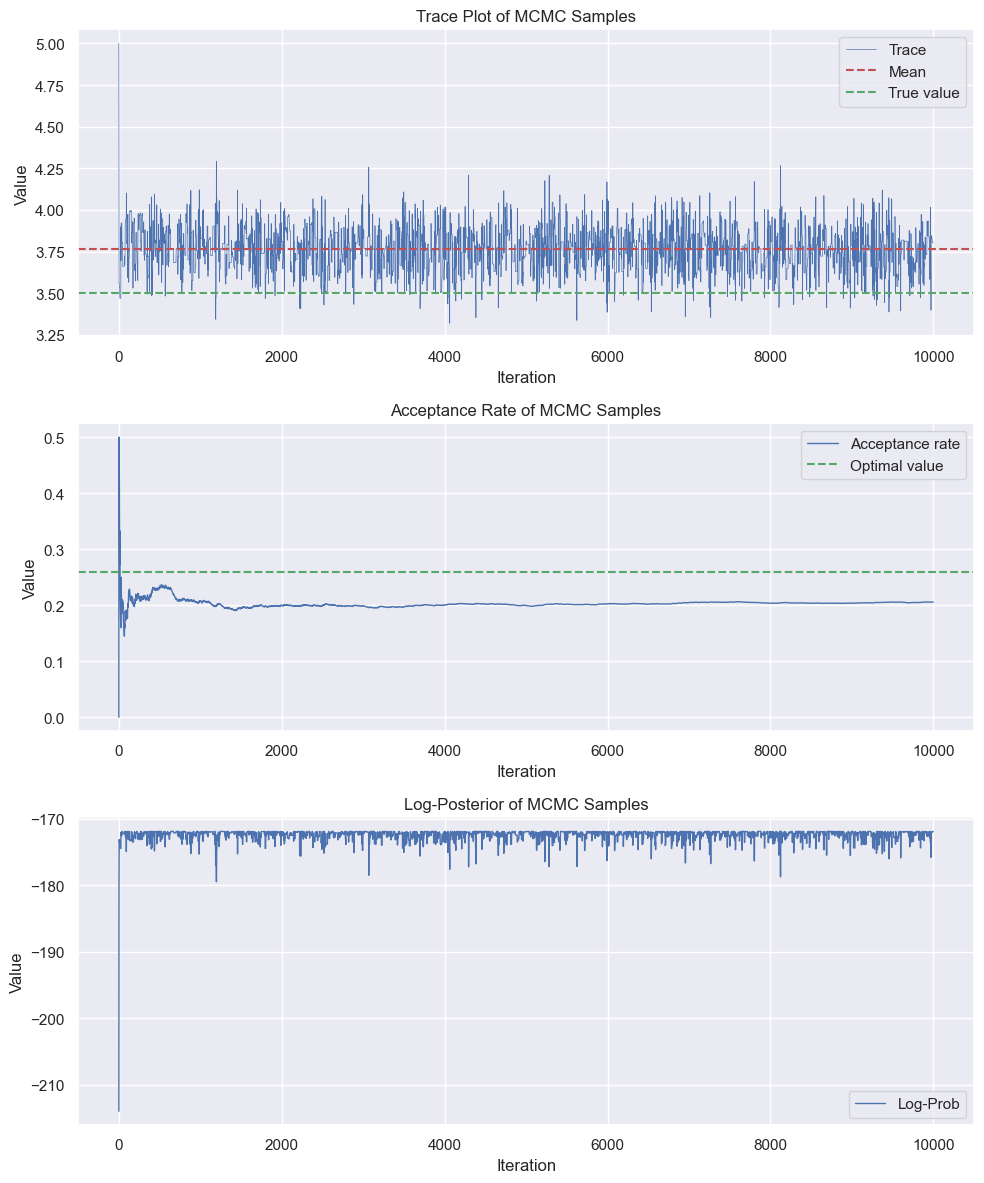

In [94]:
# Create a figure with subplots
fig, axs = plt.subplots(3,1, figsize=(10, 12))

# Trace plot
axs[0].plot(chains, linestyle='-', color='b', label='Trace', linewidth = 0.5)
axs[0].axhline(y=np.mean(chains), color='r', linestyle='--', label='Mean',linewidth = 1.5)
axs[0].axhline(y=3.5, color='g', linestyle='--', label='True value', linewidth = 1.5)
# Add labels and title
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('Trace Plot of MCMC Samples')
axs[0].legend()

# Acceptance rate plot 
axs[1].plot(np.cumsum(results[0].is_accepted)/range(1, N+1), linestyle='-', color='b', label='Acceptance rate', linewidth = 1)
axs[1].axhline(y=0.26, color='g', linestyle='--', label='Optimal value', linewidth = 1.5)
# Add labels and title
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('Acceptance Rate of MCMC Samples')
axs[1].legend()

# Log posterior plot
axs[2].plot(results[0].current_state_log_prob, linestyle='-', color='b', label='Log-Prob', linewidth = 1)
# Add labels and title
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Value')
axs[2].set_title('Log-Posterior of MCMC Samples')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [95]:
pd.DataFrame(chains, columns= ['Value']).describe()

,Value
count,10000.000000
mean,3.766069
std,0.132418
min,3.319022
25%,3.675319
50%,3.769753
75%,3.854795
max,5.000000


In [96]:
# adaptive MCMC proposal variance 
(2.38**2)*np.std(chains) 

0.7500315577682171

# IS-MCMC Implementation

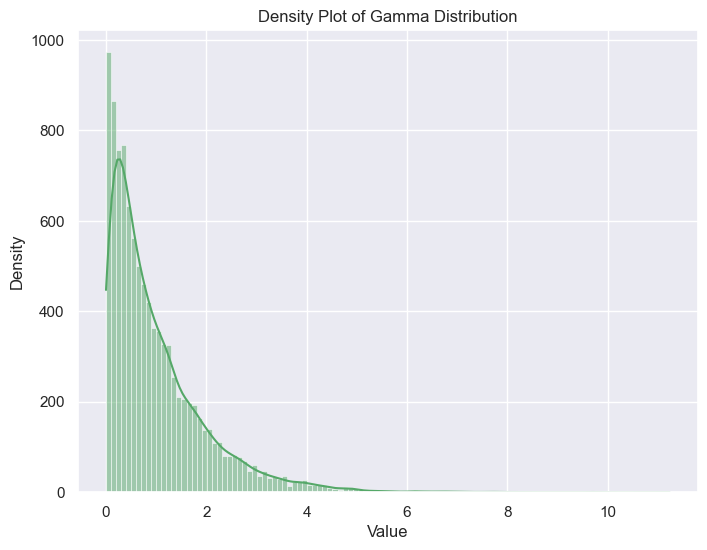

In [104]:
# Simulate 10,000 points from a gamma distribution with shape=2 and scale=1
gamma_samples = np.random.gamma(shape=1, scale=1, size=10000)

# Create a density plot
plt.figure(figsize=(8, 6))
sns.histplot(gamma_samples, kde=True, color='g', label='Density Plot')
plt.title('Density Plot of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

# Show the plot
plt.show()

In [105]:
IS_kernel_output_structure, IS_kernel_fn = independence_sampler_kernel(target_log_prob_fn=tlp_fixed_loc_moving_scale,
                                                                       initial_state=tf.constant(
                                                                           0, dtype=DTYPE),
                                                                       proposal_distribution=generate_gamma_proposal(distribution_parameters=tf.constant([1, 1], dtype=DTYPE)))

In [106]:
### N = 10_000

chains, results = sample_chain(
    current_state=tf.constant(0, dtype=DTYPE),
    previous_kernel_results=IS_kernel_output_structure,
    kernel=IS_kernel_fn,
    seed=20220807,
    num_results=N)

# IS-MCMC Diagnostics

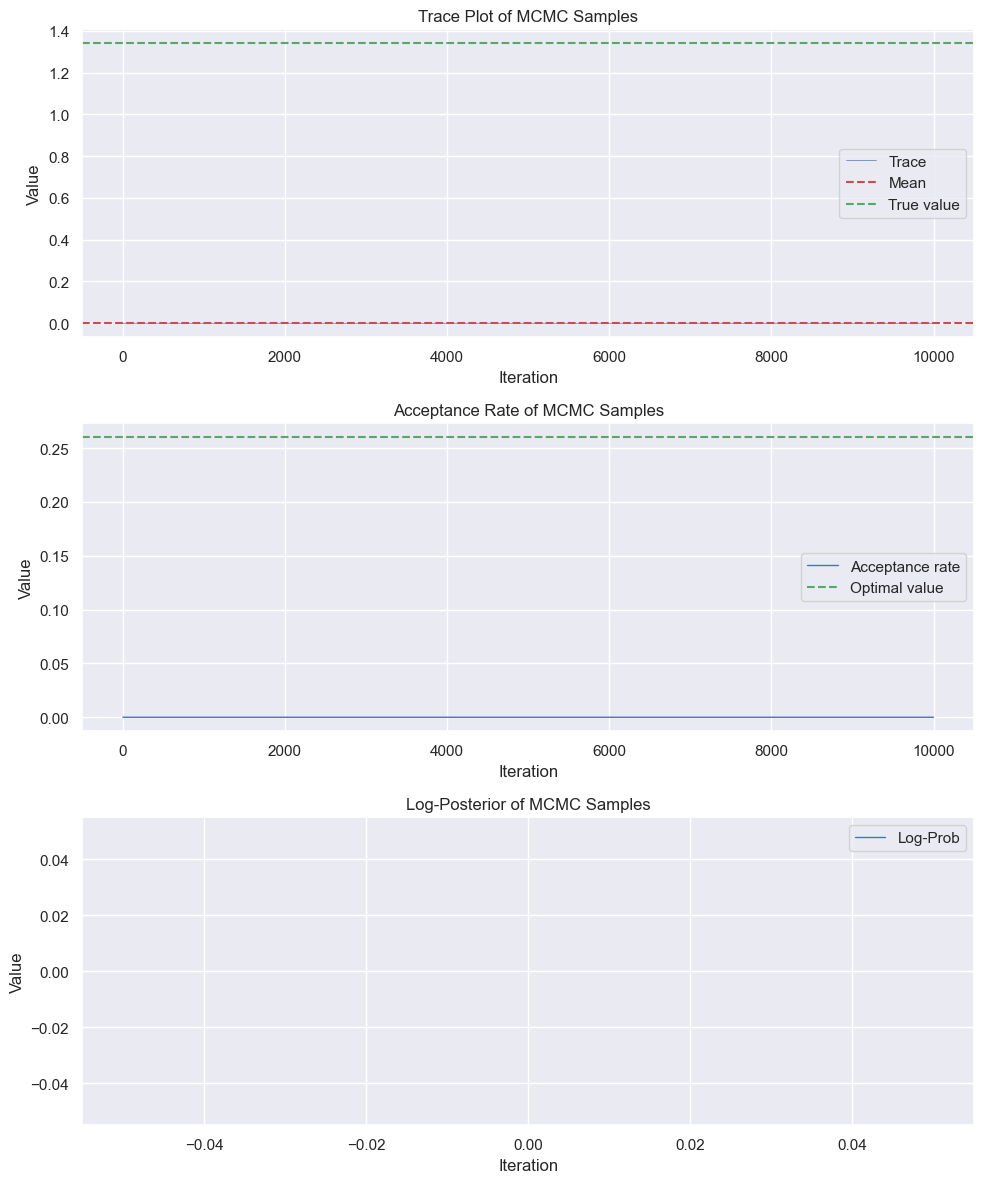

In [107]:
# Create a figure with subplots
fig, axs = plt.subplots(3,1, figsize=(10, 12))

# Trace plot
axs[0].plot(chains, linestyle='-', color='b', label='Trace', linewidth = 0.5)
axs[0].axhline(y=np.mean(chains), color='r', linestyle='--', label='Mean',linewidth = 1.5)
axs[0].axhline(y=tf.constant(1.34, dtype=DTYPE), color='g', linestyle='--', label='True value', linewidth = 1.5)
# Add labels and title
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('Trace Plot of MCMC Samples')
axs[0].legend()

# Acceptance rate plot 
axs[1].plot(np.cumsum(results[0].is_accepted)/range(1, N+1), linestyle='-', color='b', label='Acceptance rate', linewidth = 1)
axs[1].axhline(y=0.26, color='g', linestyle='--', label='Optimal value', linewidth = 1.5)
# Add labels and title
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('Acceptance Rate of MCMC Samples')
axs[1].legend()

# Log posterior plot
axs[2].plot(results[0].current_state_log_prob, linestyle='-', color='b', label='Log-Prob', linewidth = 1)
# Add labels and title
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Value')
axs[2].set_title('Log-Posterior of MCMC Samples')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [101]:
pd.DataFrame(chains, columns= ['Value']).describe()

,Value
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [102]:
# acceptance rate: 
print(f'MCMC sampler acceptance rate: {100*np.sum(results[0].is_accepted)/N}%')

MCMC sampler acceptance rate: 0.0%


# Chained kernels

In [103]:
# Notation we use for "super" kernels 
# K(x,y) = k_1(x',y) >> k_2 (x', y') >>  K(x',y')

def generate_super_kernel(subkernel_tuple, initial_state):
    
    return 42